In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"

In [4]:
device

device(type='cuda', index=0)

In [13]:
input_folder_path = "mnist_data/"
train_df = pd.read_csv(input_folder_path+"train.csv")
test_df = pd.read_csv(input_folder_path+"test.csv")

In [14]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
train_df.shape

(42000, 785)

In [16]:
train_labels = train_df["label"].values
train_images = (train_df.iloc[:,1:].values).astype("float32")
test_images = (test_df.iloc[:,:].values).astype("float32")

In [17]:
#Training and Validation Split
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels,
                                                                     stratify=train_labels, random_state=123,
                                                                     test_size=0.20)

In [18]:
train_images[0].shape

(784,)

In [19]:
train_images = train_images.reshape(train_images.shape[0], 28, 28)
val_images = val_images.reshape(val_images.shape[0], 28, 28)
test_images = test_images.reshape(test_images.shape[0], 28, 28)

In [20]:
train_images[0].shape

(28, 28)

In [21]:
train_images.shape

(33600, 28, 28)

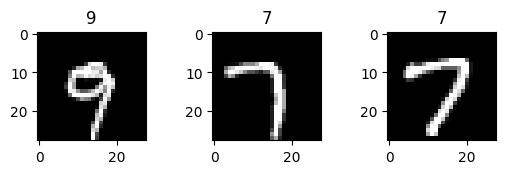

In [22]:
#train samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(train_images[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(train_labels[i])

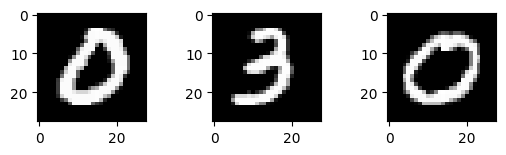

In [23]:
#test samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(test_images[i].squeeze(), cmap=plt.get_cmap('gray'))

In [24]:
#train
train_images_tensor = torch.tensor(train_images) / 255.0
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)

#val
val_images_tensor = torch.tensor(val_images) / 255.0
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)

#test
test_images_tensor = torch.tensor(test_images) / 255.0

In [27]:
train_loader = DataLoader(train_tensor, batch_size=16, num_workers=2, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=16, num_workers=2, shuffle=True)
test_loader = DataLoader(test_images_tensor, batch_size=16, num_workers=2, shuffle=False)

In [31]:
next(train_loader.__iter__())[1].shape

torch.Size([16])

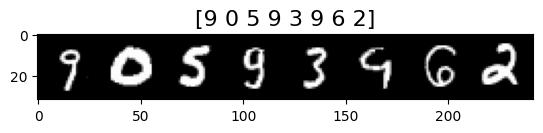

In [32]:
for batch_idx, (data, target) in enumerate(train_loader):
    img_grid = make_grid(data[0:8,].unsqueeze(1), nrow=8)
    img_target_labels = target[0:8,].numpy()
    break
    
plt.imshow(img_grid.numpy().transpose((1,2,0)))
plt.rcParams['figure.figsize'] = (10, 2)
plt.title(img_target_labels, size=16)
plt.show()

In [33]:
class DenseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = x.view(x.size(0), -1)
        x = self.fc4(x)
        
        return x

In [43]:
dense_model = DenseNet().to(device)
print(dense_model)

DenseNet(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


In [44]:
optimizer = optim.Adam(params=dense_model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

#exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [45]:
if torch.cuda.is_available():
    dense_model = dense_model.cuda()
    criterion = criterion.cuda()

In [46]:
num_epochs = 10
num_batchs = len(train_loader)

for n in range(num_epochs):
    epoch_loss = 0
    dense_model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.unsqueeze(1)
        data = data.reshape(16, 1, 28*28)
        #print(f"Input data shape : {data.shape}")
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        output = dense_model(data)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    mean_loss = epoch_loss / num_batchs

    print(f"epoch {n} - Train loss : {mean_loss}")

    # Evaluation
    dense_model.eval()
    loss = 0
    correct = 0
    
    for data, target in val_loader:
        data = data.unsqueeze(1)
        data = data.reshape(16, 1, 28*28)
        #data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = dense_model(data)
        
        loss += F.cross_entropy(output, target, size_average=False).item()

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(val_loader)
    accuracy = correct / len(val_loader.dataset)

    print(f"epoch {n} - Val loss : {loss} - Val accuracy : {accuracy}")
        


epoch 0 - Train loss : 0.33750419564633855
epoch 0 - Val loss : 3.864981720639127 - Val accuracy : 0.9276190400123596
epoch 1 - Train loss : 0.16894443658244285
epoch 1 - Val loss : 2.428855938741139 - Val accuracy : 0.9532142877578735
epoch 2 - Train loss : 0.13370386296710682
epoch 2 - Val loss : 2.558121435797463 - Val accuracy : 0.9534524083137512
epoch 3 - Train loss : 0.11093232594231571
epoch 3 - Val loss : 2.0940394119953827 - Val accuracy : 0.9640476107597351
epoch 4 - Train loss : 0.09554648683178432
epoch 4 - Val loss : 2.3296765721961856 - Val accuracy : 0.9602380990982056
epoch 5 - Train loss : 0.08639140715358995
epoch 5 - Val loss : 2.2570676931961704 - Val accuracy : 0.965238094329834
epoch 6 - Train loss : 0.07858463287194224
epoch 6 - Val loss : 2.206815962057472 - Val accuracy : 0.9649999737739563
epoch 7 - Train loss : 0.07324931263262659
epoch 7 - Val loss : 2.2953359879038873 - Val accuracy : 0.9629762172698975
epoch 8 - Train loss : 0.0661786973496527
epoch 8 - V

In [53]:
def train_model(model, data_loader, optimizer, criterion, num_epoch, flatten=True):
    model.train()
    epoch_loss = 0
    num_batchs = len(data_loader)
    
    for batch_idx, (data, target) in enumerate(data_loader):
        data = data.unsqueeze(1)
        if flatten:
            data = data.reshape(16, 1, 28*28)
        #print(data.shape)
        #data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
            
        optimizer.zero_grad()
        output = model(data)

        #print(f"output : {output.shape}")
        #print(f"target : {target.shape}")

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        #lr_scheduler.step()

        epoch_loss += loss.item()
    
    return epoch_loss / num_batchs

In [54]:
def evaluate(model, data_loader, flatten=True):
    model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data = data.unsqueeze(1)
        if flatten:
            data = data.reshape(16, 1, 28*28)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss += F.cross_entropy(output, target, size_average=False).item()

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader)
    accuracy = correct / len(data_loader.dataset)

    return loss, accuracy

In [146]:
num_epochs = 25

for n in range(num_epochs):
    train_loss = train_model(dense_model, train_loader, optimizer, criterion, exp_lr_scheduler, n)
    print(f"epoch {n} - Train loss : {train_loss}")
    val_loss, accuracy = evaluate(dense_model, val_loader)
    print(f"epoch {n} - Val loss : {val_loss} - Val accuracy : {accuracy}")

epoch 0 - Train loss : 0.32675819988961197
epoch 0 - Val loss : 3.012940400327955 - Val accuracy : 0.942976176738739
epoch 1 - Train loss : 0.1641078255970275
epoch 1 - Val loss : 2.368455589081915 - Val accuracy : 0.9569047689437866
epoch 2 - Train loss : 0.12624965787283837
epoch 2 - Val loss : 2.3018397422522927 - Val accuracy : 0.9589285850524902
epoch 3 - Train loss : 0.10768756986142156
epoch 3 - Val loss : 2.598621252742818 - Val accuracy : 0.9521428346633911
epoch 4 - Train loss : 0.09829306540326538
epoch 4 - Val loss : 2.841120676527332 - Val accuracy : 0.9528571367263794
epoch 5 - Train loss : 0.08387494546846679
epoch 5 - Val loss : 3.138117232984375 - Val accuracy : 0.954880952835083
epoch 6 - Train loss : 0.0807407611206763
epoch 6 - Val loss : 2.287282966495092 - Val accuracy : 0.9590476155281067
epoch 7 - Train loss : 0.0737348980344896
epoch 7 - Val loss : 2.084565751926552 - Val accuracy : 0.967380940914154
epoch 8 - Train loss : 0.06920892989351918
epoch 8 - Val loss

KeyboardInterrupt: 

### Conv model

In [55]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

In [56]:
conv_model = ConvNet()
conv_model

ConvNet(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [57]:
optimizer = optim.Adam(params=conv_model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    conv_model = conv_model.cuda()
    criterion = criterion.cuda()

In [58]:
num_epochs = 20

for n in range(num_epochs):
    train_loss = train_model(conv_model, train_loader, optimizer, criterion, n, flatten=False)
    print(f"epoch {n} - Train loss : {train_loss}")
    val_loss, accuracy = evaluate(conv_model, val_loader, flatten=False)
    print(f"epoch {n} - Val loss : {val_loss} - Val accuracy : {accuracy}")

epoch 0 - Train loss : 0.40075199287606494
epoch 0 - Val loss : 0.8468293209569085 - Val accuracy : 0.9846428632736206
epoch 1 - Train loss : 0.2096123305428773
epoch 1 - Val loss : 0.8568136154740517 - Val accuracy : 0.9851190447807312
epoch 2 - Train loss : 0.18012927032574746
epoch 2 - Val loss : 0.6763386982413275 - Val accuracy : 0.9878571629524231
epoch 3 - Train loss : 0.162756334173166
epoch 3 - Val loss : 0.6966680248498562 - Val accuracy : 0.9867857098579407
epoch 4 - Train loss : 0.14521964815611552
epoch 4 - Val loss : 0.5591525091851751 - Val accuracy : 0.9904761910438538
epoch 5 - Train loss : 0.13287065873465811
epoch 5 - Val loss : 0.5101416489178138 - Val accuracy : 0.9913095235824585
epoch 6 - Train loss : 0.12308665381544935
epoch 6 - Val loss : 0.4557203696385425 - Val accuracy : 0.9917857050895691
epoch 7 - Train loss : 0.12221968685779887
epoch 7 - Val loss : 0.4378490547828066 - Val accuracy : 0.9932143092155457
epoch 8 - Train loss : 0.1088997315203527
epoch 8 -

In [ ]:


EPOCHS = 10


for epoch in range(EPOCHS):
    epoch_loss = 0
    n_iter = 0
    for data in trainset:
        X, y = data
        X = X.to(device)
        y = y.to(device)
        net.zero_grad()
        output = net(X.view(-1, 28*28))
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
        n_iter += 1
    print(f"Epoch {epoch} - loss : {epoch_loss / n_iter}")

In [40]:
# Training data
train = datasets.MNIST("", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

# Testing data
test = datasets.MNIST("", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

In [41]:
#train.data = train.data.to(device)
#train.targets = train.targets.to(device)

In [42]:
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [43]:
train[6]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [45]:
trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)

In [46]:
trainset

In [47]:
next(trainset.__iter__())[0].shape

torch.Size([10, 1, 28, 28])

## Deep Learning

In [48]:
28*28

784

In [59]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

net = Net().to(device)
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


In [60]:
optimizer = optim.Adam(net.parameters(), lr =0.001)

EPOCHS = 10


for epoch in range(EPOCHS):
    epoch_loss = 0
    n_iter = 0
    for data in trainset:
        X, y = data
        X = X.to(device)
        y = y.to(device)
        net.zero_grad()
        output = net(X.view(-1, 28*28))
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
        n_iter += 1
    print(f"Epoch {epoch} - loss : {epoch_loss / n_iter}")

Epoch 0 - loss : 0.26950111985206604
Epoch 1 - loss : 0.12329638749361038
Epoch 2 - loss : 0.09322883933782578
Epoch 3 - loss : 0.07598932087421417
Epoch 4 - loss : 0.0629969909787178
Epoch 5 - loss : 0.056183360517024994
Epoch 6 - loss : 0.048178303986787796
Epoch 7 - loss : 0.04380401596426964
Epoch 8 - loss : 0.040013253688812256
Epoch 9 - loss : 0.03758767992258072


In [62]:
# Calculating Accuracy

correct = 0
total = 0

with torch.no_grad():
     for data in trainset:
            X, y = data
            X = X.to(device)
            y = y.to(device)
            output = net(X.view(-1, 784))
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                total +=1
                
print("Accuracy: ", round(correct/total, 3))

Accuracy:  0.989
